In [1]:
# %pip install --upgrade tf-nightly-gpu

In [1]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img

from sklearn.model_selection import train_test_split

import numpy as np
import cv2
import os

import PIL
import PIL.Image
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

2021-09-25 16:47:39.674841: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-25 16:47:39.674873: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
import sys
if '..' not in sys.path: sys.path.append('..')

from scr import train

In [3]:
images_path = '../data/dataset/dataset/training_data/images'

In [4]:
train_df = train.Train().get_annotation()
train_df = train_df[(train_df.label == 'other')&(train_df.text.str.contains('(^\d{5,10})|(\d{5,10}$)'))]
train_df

/tmp/ipykernel_89419/762169767.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  train_df = train_df[(train_df.label == 'other')&(train_df.text.str.contains('(^\d{5,10})|(\d{5,10}$)'))]


,box,text,label,words,linking,id,fil_name
2,"[661, 691, 678, 762]",9135631,other,"[{'box': [661, 691, 678, 762], 'text': '913563...",[],2,91356315
31,"[683, 785, 698, 853]",93213298,other,"[{'box': [683, 785, 698, 853], 'text': '932132...",[],31,93213298
22,"[49, 797, 84, 812]",10111,other,"[{'box': [49, 797, 84, 812], 'text': '10111'}]",[],22,0012178355
23,"[560, 845, 675, 867]",621626776,other,"[{'box': [560, 845, 675, 867], 'text': '621626...",[],23,0012178355
5,"[665, 768, 683, 863]",01197604,other,"[{'box': [665, 768, 683, 863], 'text': '011976...",[],5,01197604
...,...,...,...,...,...,...,...
16,"[520, 894, 630, 913]",620753790,other,"[{'box': [520, 894, 630, 913], 'text': '620753...",[],16,0001456787
27,"[658, 768, 676, 862]",00283913,other,"[{'box': [658, 768, 676, 862], 'text': '002839...",[],27,00283813
30,"[677, 781, 697, 889]",81619511,other,"[{'box': [677, 781, 697, 889], 'text': '816195...",[],30,81619511_9513
7,"[737, 825, 762, 900]",91581919,other,"[{'box': [737, 825, 762, 900], 'text': '915819...",[],7,91581919


## Загрузка данных в списки

In [5]:
data = []
targets = []
filenames = []

sithe = 512

for name in train_df.fil_name.unique():
    filename = name + '.png'
    image_path = f'{images_path}/{filename}'
    image = cv2.imread(image_path)    
    (h, w) = image.shape[:2]
    
    row = train_df.loc[train_df.fil_name == name, 'box'].max()
    (startX, startY, endX, endY) = row
    startX = float(startX) / w
    startY = float(startY) / h
    endX = float(endX) / w
    endY = float(endY) / h
    
    image = load_img(image_path, target_size=(sithe, sithe))
    image = img_to_array(image)
    
    data.append(image)
    targets.append((startX, startY, endX, endY))
    filenames.append(filename)
# data, '\n', targets, '\n',  filenames
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


512 512
0.9058355437665783 0.785 0.9257294429708223 0.853
463.7877984084881 401.92 10.18567639257293 34.815999999999974


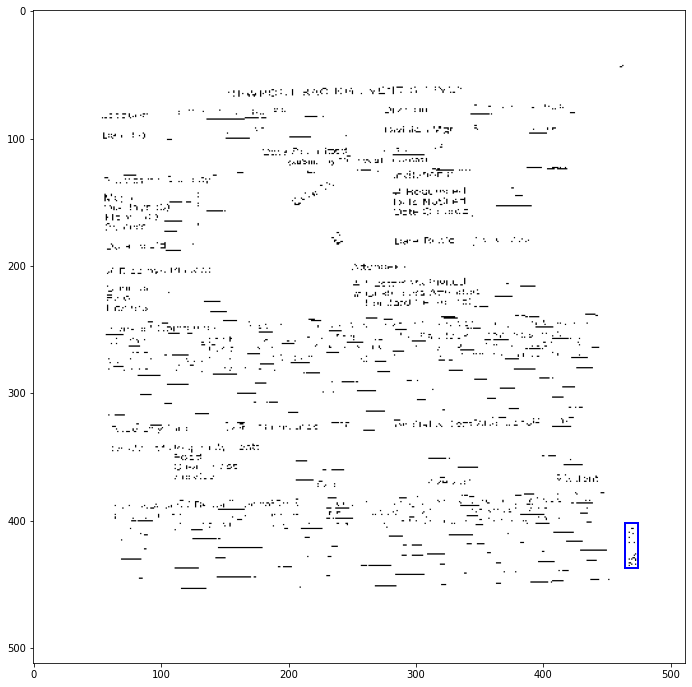

In [6]:
i = 1
fig,ax = plt.subplots(figsize=(12, 12))
plt.imshow(data[i], cmap="binary")
H, W, _ = data[i].shape
print(W, H)
startX, startY, endX, endY = targets[i]
print(startX, startY, endX, endY)
x = startX * W
y = startY * H
w = (endX - startX) * W
h = (endY - startY) * H

rect = patches.Rectangle((x, y), w , h, lw=2,
                                 ec ='b', facecolor='none')
print(x, y, w, h)
ax.add_patch(rect)
plt.show()

In [23]:
data = np.array(data, dtype="float32") / 255.0
targets = np.array(targets, dtype="float32")
split = train_test_split(data, targets, filenames, test_size=0.10,
	random_state=42)
(trainImages, testImages) = split[:2]
(trainTargets, testTargets) = split[2:4]
(trainFilenames, testFilenames) = split[4:]

In [24]:
vgg = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(sithe, sithe, 3)))

In [25]:
vgg.trainable = False
flatten = vgg.output
flatten = Flatten()(flatten)
bboxHead = Dense(256, activation="relu")(flatten)
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid")(bboxHead)
model = Model(inputs=vgg.input, 
              outputs=bboxHead
             )

In [26]:
opt = Adam(
    learning_rate = 1e-4
)
model.compile(loss="mse", optimizer=opt)
# print(model.summary())

In [12]:
trainImages[0].shape

(512, 512, 3)

In [ ]:
print("[INFO] training bounding box regressor...")
H = model.fit(
	trainImages, trainTargets,
	validation_data=(testImages, testTargets),
	batch_size=16,
	epochs=5,
	verbose=1
)

[INFO] training bounding box regressor...
Epoch 1/5


In [27]:
from keras.models import load_model
path = '../scr/segm_model'
model.save(path)
# model = load_model(path)

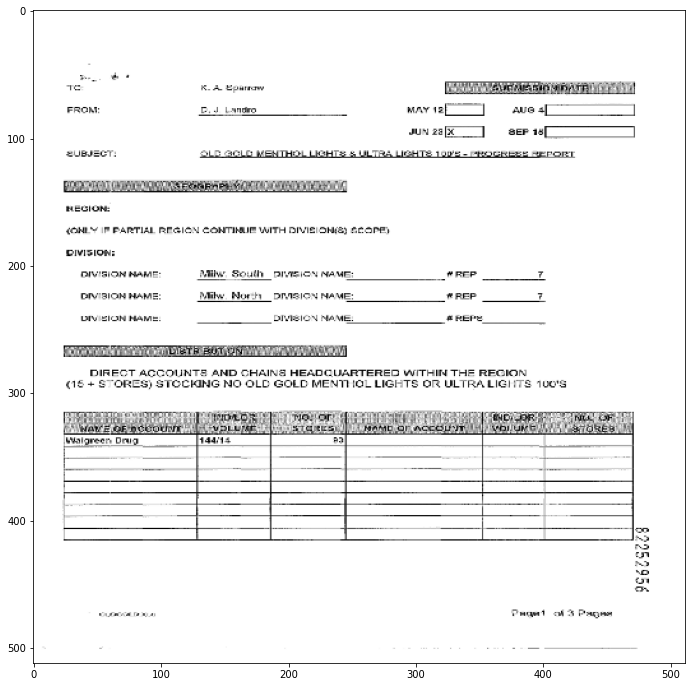

In [14]:
test_im_path = r'../data/dataset/dataset/testing_data/images/82252956_2958.png'
# test_im_path = r'../data/dataset/dataset/training_data/images/0000971160.png'
test_im = load_img(test_im_path, target_size=(sithe, sithe))
test_im = img_to_array(test_im) / 255.0
fig,ax = plt.subplots(figsize=(12, 12))
plt.imshow(test_im, cmap="binary")
test_im = np.expand_dims(test_im, axis=0)

In [12]:
print(test_im.shape)
preds = model.predict(test_im)
preds

(1, 512, 512, 3)


array([[0.7268745 , 0.76478875, 0.81055295, 0.839357  ]], dtype=float32)

[0.7268745  0.76478875 0.81055295 0.839357  ]
548.0633509159088 764.7887468338013 63.09357690811157 74.56827163696289


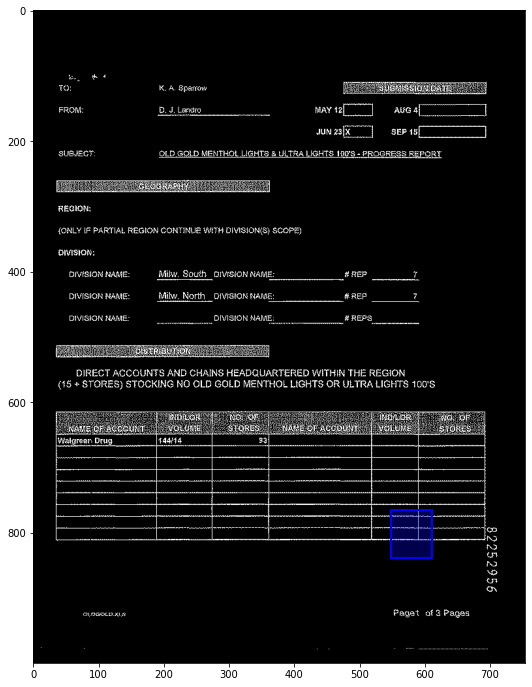

[False  True]


In [13]:
im = np.array(PIL.Image.open(test_im_path).convert("1"))
H, W = im.shape
fig,ax = plt.subplots(figsize=(12, 12))
plt.imshow(im, cmap="binary")
for lb in preds:
    print(lb)
    startX, startY, endX, endY = lb
    x = startX * W
    y = startY * H
    w = (endX - startX) * W
    h = (endY - startY) * H
    
    print(x, y, w, h)
    rect = patches.Rectangle((x, y), w, h, linewidth=1, lw = 2,
                             fc ='b', facecolor='none',alpha = 0.3)
    ax.add_patch(rect)
    rect = patches.Rectangle((x, y), w, h, lw=2,
                             ec ='b', facecolor='none')
    ax.add_patch(rect)
plt.show()
print(np.unique(im))